In [251]:
# Importando bibliotecas
import pandas as pd
import numpy as np
from uuid import uuid4

In [252]:
# Lendo os arquivos
netflix_titles = pd.read_csv("C:/Users/amand/Documents/DataScience/data-challenge-20221121/data/netflix_titles.csv")
amazon_titles = pd.read_csv("C:/Users/amand/Documents/DataScience/data-challenge-20221121/data/amazon_prime_titles.csv")

### Unificando as bases de dados

In [253]:
# Criando id único para cada registro
def add_to_unique_data_set(dataframe):
    for index in dataframe.index:
        dataframe.loc[index, 'id'] = str(uuid4())

add_to_unique_data_set(netflix_titles)
add_to_unique_data_set(amazon_titles)

In [254]:
# Criando coluna para identificar a plataforma de origem
netflix_titles['platform'] = 'Netflix'
amazon_titles['platform'] = 'Amazon Prime'

In [255]:
# Mesclando as bases de dados e resetando o index do novo dataframe
titles = pd.concat([netflix_titles, amazon_titles], ignore_index=True)

In [256]:
# Conferindo a quantidade de registros no novo dataframe
titles[['platform', 'id']].groupby('platform').count()

,id
platform,
Amazon Prime,9668
Netflix,8807


### Entendendo os dados

In [257]:
# titles.head()

In [258]:
# titles.tail()

In [259]:
# titles.info()

In [260]:
titles.isna().sum()

show_id            0
type               0
title              0
director        4716
cast            2058
country         9827
date_added      9523
release_year       0
rating           341
duration           3
listed_in          0
description        0
id                 0
platform           0
dtype: int64

In [261]:
# titles.cast.value_counts()

### Tratando os dados

In [262]:
## Criando funções para serem utilizadas

# Criando uma função para formatar corretamente os dados necessários em listas

def fomarting_lists_from_columns(dataframe, column_name):

    for index in dataframe.index:
        if dataframe.loc[index,column_name] != '':
            string_list = dataframe.loc[index, column_name]
            converted_list = string_list.split(',')
            treated_list = [[s.strip()] for s in converted_list]

            dataframe.loc[index,  f'treated_{column_name}'] = treated_list

# Criando função para higienizar dados nas colunas através de um dicionário

def replace_categories(dataframe, column_name, replacement_dict):
    dataframe[column_name] = dataframe[column_name].replace(replacement_dict, regex=True)
    return dataframe

In [263]:
# Convertendo a coluna de datas para datetime
titles.date_added = pd.to_datetime(titles.date_added)

In [264]:
## Testando se excluir os dados nulos causaria diferença
# titles_month = titles.loc[(titles.platform == 'Netflix')].copy()
# titles_month.dropna(subset=['date_added'], inplace=True)
# titles_month['month_added'] = titles_month.date_added.dt.month_name()
# titles_month.month_added.value_counts()

In [265]:
# Criando a coluna month_added para possbilitar análises a partir apenas do mês
titles['month_added'] = titles.date_added.dt.month_name()

In [266]:
# Criando dicionário para tratar os dados de categorias e possbilitar a divisão correta das categorias
listed_in_replacement_dict = {'Action & Adventure': 'Action, Adventure',
                            'Sci-Fi & Fantasy': 'Sci-Fi, Fantasy'}
                    

# Aplicando a função de higienização para a coluna de países
titles = replace_categories(titles, 'listed_in', listed_in_replacement_dict)

In [267]:
# Aplicando a para formatar corretamente os dados necessários em listas

titles.cast.fillna('', inplace=True)
titles.country.fillna('', inplace=True)

fomarting_lists_from_columns(titles, 'cast')
fomarting_lists_from_columns(titles, 'country')
fomarting_lists_from_columns(titles, 'listed_in')

In [268]:
# Criando dataframe auxiliar, transformando a coluna de listas em uma coluna com cada item da lista em uma nova linha
## para a coluna cast
df_cast = titles.explode('treated_cast')


In [269]:
# Criando dataframe auxiliar, transformando a coluna de listas em uma coluna com cada item da lista em uma nova linha
## para a coluna country
df_country = titles.explode('treated_country')


In [270]:
# Criando dataframe auxiliar, transformando a coluna de listas em uma coluna com cada item da lista em uma nova linha
## para a coluna listed_in
df_listed_in = titles.explode('treated_listed_in')

In [271]:
# Entendendo quais tratamentos precisam ser feitos para higienizar a coluna de países
# country_list = df_country['treated_country'].unique().tolist()
# country_list.sort
# country_list

In [272]:
# Criando dicionário para higienizar os dados dos países
country_replacement_dict = {'': np.nan}
                    

# Aplicando a função de higienização para a coluna de países
df_country = replace_categories(df_country, 'treated_country', country_replacement_dict)

In [299]:
# titles.listed_in[titles['listed_in'].str.contains('&')].unique()

In [274]:
# Criando dicionário para higienizar os dados das categorias
category_replacement_dict = {'Comedies': 'Comedy', 
                            'Documentaries': 'Documentary',
                            'TV ': '',
                            ' TV': '',
                            'Movies ': '',
                            ' Movies': '',
                            'Shows ': '',
                            ' Shows': '',
                            '&': 'and',
                            'and Culture': 'Culture',
                            'Dramas': 'Drama',
                            "Kids'": 'Kids',
                            'Anime Features': 'Anime',
                            'Anime Series': 'Anime',
                            'Romantic': 'Romance',
                            'Science Fiction': 'Sci-Fi' }

# Aplicando a função de higienização para as coluna de categorias
df_listed_in = replace_categories(df_listed_in, 'treated_listed_in', category_replacement_dict)

### Filtrando os dados

#### 1- Top 10 atores/atrizes considerando todos os dados;

In [275]:
# Rankeando os 10 atores que estão em mais filmes
top_ten_actors = df_cast.treated_cast.value_counts().nlargest(10)
print(f'''Os 10 atores e atrizes que mais aparecem nas pruduções presentes na base de dados são:
{top_ten_actors}.''')

Os 10 atores e atrizes que mais aparecem nas pruduções presentes na base de dados são:
Anupam Kher         59
Maggie Binkley      56
Amitabh Bachchan    47
Shah Rukh Khan      46
Nassar              43
Akshay Kumar        41
Paresh Rawal        39
Naseeruddin Shah    39
Danny Trejo         39
Om Puri             35
Name: treated_cast, dtype: int64.


In [354]:
df_top_ten_actors = pd.DataFrame(df_cast.treated_cast.value_counts().reset_index().rename(columns={'index': 'actor_name', 'treated_cast': 'count'}))
df_top_ten_actors

,actor_name,count
0,Anupam Kher,59
1,Maggie Binkley,56
2,Amitabh Bachchan,47
3,Shah Rukh Khan,46
4,Nassar,43
...,...,...
60756,Michael Patrick Bell,1
60757,Lam Ka Tung,1
60758,Wong You-nam,1
60759,Darren Shahlavi,1


In [343]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style('ticks')
plt.style.use('ggplot')
# plt.xticks(rotation=45)
# plt.xticks(rotation=45)
# plt.xticks(fontsize=10)

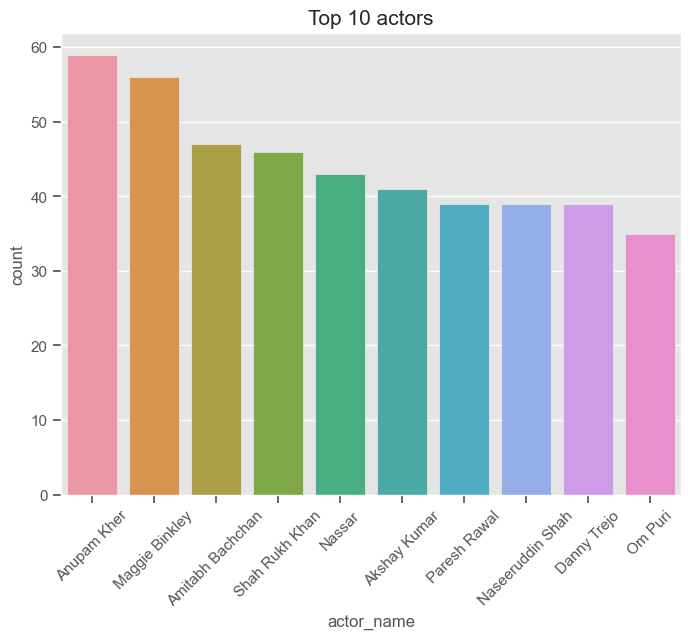

In [342]:
chart_top_ten_actors = sns.barplot(data=df_top_ten_actors.head(10), x='actor_name', y='count')
plt.xticks(rotation=45)
chart_top_ten_actors.set_title('Top 10 actors', fontsize = 15)
plt.show(chart_top_ten_actors)
# ax.set_xlabel(fontsize = 15)
# ax.set_ylabel(‘valor’,fontsize=15)

#### 2- Top 5 países produtores de conteúdos considerando todos os dados e comparando as duas plataformas;

In [276]:
# Conferindo a relevância das datas faltantes dentro do subconjundo a ser analisado
subset = titles.shape[0]
subset_missing_values = titles.loc[titles.treated_country.isna()].shape[0]

print("{} linhas com dado faltando, o equivalente a {}% do subconjunto de dados a ser analisado por essa dimensão.".format(subset_missing_values, (subset_missing_values/subset)*100))

9827 linhas com dado faltando, o equivalente a 53.190798376184034% do subconjunto de dados a ser analisado por essa dimensão.


In [277]:
# Rankeando os 5 países produtores de conteúdo na base completa
top_five_country_all = df_country.treated_country.value_counts().nlargest(5)
print(f'''Os 5 maiores países produtores de conteúdo de toda a base de dados são:
{top_five_country_all}.''')

Os 5 maiores países produtores de conteúdo de toda a base de dados são:
United States     4024
India             1292
United Kingdom     873
Canada             480
France             413
Name: treated_country, dtype: int64.


In [356]:
df_top_five_country= pd.DataFrame(df_country[['platform', 'treated_country']].value_counts().reset_index().rename(columns={'treated_country': 'country', 0:'count'}))
# df_top_ten_actors.rename(columns={'index': 'actor_name', 'treated_cast': 'count'}, inplace=True)
df_top_five_country

,platform,country,count
0,Netflix,United States,3690
1,Netflix,India,1046
2,Netflix,United Kingdom,806
3,Netflix,Canada,445
4,Netflix,France,393
...,...,...,...
162,Netflix,Paraguay,1
163,Netflix,Albania,1
164,Amazon Prime,Albania,1
165,Amazon Prime,United Arab Emirates,1


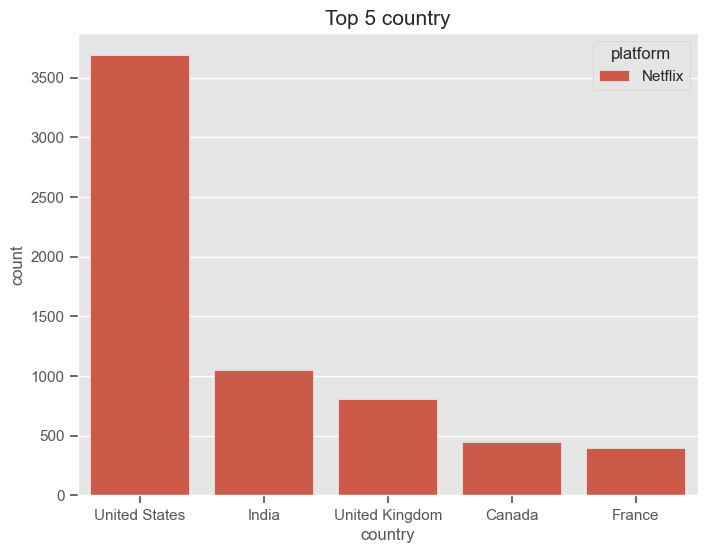

In [362]:
chart_top_five_country = sns.barplot(data=df_top_five_country.head(5), x='country', y='count', hue='platform')
chart_top_five_country.set_title('Top 5 country', fontsize = 15)
plt.show(chart_top_five_country)

In [278]:
# Conferindo a relevância das datas faltantes dentro do subconjundo a ser analisado
subset = titles.loc[(titles.platform == 'Netflix')].shape[0]
subset_missing_values = titles.loc[(titles.platform == 'Netflix') & (titles.treated_country.isna())].shape[0]

print("{} linhas com dado faltando, o equivalente a {}% do subconjunto de dados a ser analisado por essa dimensão.".format(subset_missing_values, (subset_missing_values/subset)*100))

831 linhas com dado faltando, o equivalente a 9.435676166685592% do subconjunto de dados a ser analisado por essa dimensão.


In [279]:
# Rankeando os 5 países produtores de conteúdo da Netflix
top_5_country_netflix = df_country.treated_country.loc[df_country.platform == 'Netflix'].value_counts().nlargest(5)
print(f'''Os 5 maiores países produtores de conteúdo dos dados da platforma Netflix são:
{top_5_country_netflix}.''')

Os 5 maiores países produtores de conteúdo dos dados da platforma Netflix são:
United States     3690
India             1046
United Kingdom     806
Canada             445
France             393
Name: treated_country, dtype: int64.


In [280]:
# Conferindo a relevância das datas faltantes dentro do subconjundo a ser analisado
subset = titles.loc[(titles.platform == 'Amazon Prime')].shape[0]
subset_missing_values = titles.loc[(titles.platform == 'Amazon Prime') & (titles.treated_country.isna())].shape[0]

print("{} linhas com dado faltando, o equivalente a {}% do subconjunto de dados a ser analisado por essa dimensão.".format(subset_missing_values, (subset_missing_values/subset)*100))

8996 linhas com dado faltando, o equivalente a 93.04923458833264% do subconjunto de dados a ser analisado por essa dimensão.


In [281]:
# Rankeando os 5 países produtores de conteúdo da Amazon Prime
top_5_country_amazon = df_country.treated_country.loc[df_country.platform == 'Amazon Prime'].value_counts().nlargest(5)
print(f'''Os 5 maiores países produtores de conteúdo dos dados da platforma Amazon Prime são:
{top_5_country_amazon}.''')

Os 5 maiores países produtores de conteúdo dos dados da platforma Amazon Prime são:
United States     334
India             246
United Kingdom     67
Canada             35
France             20
Name: treated_country, dtype: int64.


In [ ]:
# Filtrando dataframe para cada plataforma
df_top_five_country_netflix = df_top_five_country[df_top_five_country['platform'] == 'Netflix'].head()
df_top_five_country_amazon= df_top_five_country[df_top_five_country['platform'] == 'Amazon Prime'].head()

# Concatenando dataframes em um só
df_top_five_platforms = pd.concat([df_top_five_country_netflix, df_top_five_country_amazon])

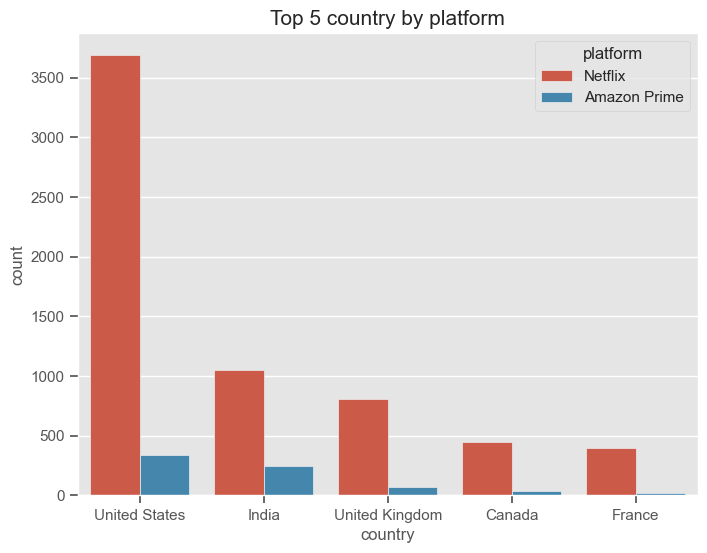

In [364]:
# Plotando gráfico de barras
chart_top_five_country_platforms = sns.barplot(data=df_top_five_platforms, x='country', y='count', hue='platform')
chart_top_five_country_platforms.set_title('Top 5 country by platform', fontsize = 15)
plt.show(chart_top_five_country_platforms)

#### 3- Mês no qual há mais adições de filmes na plataforma Netflix;

In [282]:
# Conferindo a relevância das datas faltantes dentro do subconjundo a ser analisado
subset = titles.loc[(titles.platform == 'Netflix')].shape[0]
subset_missing_values = titles.loc[(titles.platform == 'Netflix') & (titles.date_added.isna())].shape[0]

print("{} linhas com dado faltando, o equivalente a {}% do subconjunto de dados a ser analisado por essa dimensão.".format(subset_missing_values, (subset_missing_values/subset)*100))

10 linhas com dado faltando, o equivalente a 0.11354604292040424% do subconjunto de dados a ser analisado por essa dimensão.


In [367]:
titles.month_added.loc[(titles.platform == 'Netflix')].value_counts()

July         827
December     813
September    770
April        764
October      760
August       755
March        742
January      738
June         728
November     705
May          632
February     563
Name: month_added, dtype: int64

In [283]:
# Contando a quantidade de filmes em cada mês e obtendo o mês com mais filmes adcionados
most_added_month = titles.month_added.loc[(titles.platform == 'Netflix')].value_counts().idxmax()
print(f"O mês com mais filmes adicionados na plataforma Netflix foi: {most_added_month}.")

O mês com mais filmes adicionados na plataforma Netflix foi: July.


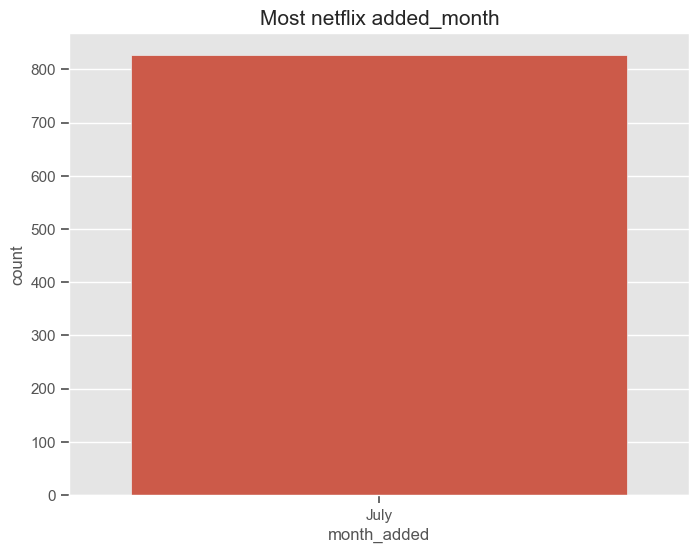

In [369]:
most_netflix_added_month = sns.countplot(data=titles.loc[(titles.platform == 'Netflix') & (titles.month_added == most_added_month)], x='month_added')
most_netflix_added_month.set_title('Most netflix added_month', fontsize = 15)
plt.show(most_netflix_added_month)

#### 4- Quantidade de filmes listados como comédia.

In [301]:
# Contabilizando os filmes listados em categorias de comédia
df_count_movies_in_comedy = df_listed_in[['type','treated_listed_in']].loc[(df_listed_in.type == 'Movie')].groupby('treated_listed_in').count().query("treated_listed_in in ('Comedy', 'Stand-Up Comedy')").reset_index()

total_movies_in_comedy = df_count_movies_in_comedy.type.sum()

print(f"A quantidade de filmes listados é: {total_movies_in_comedy}.")

A quantidade de filmes listados é: 3838.


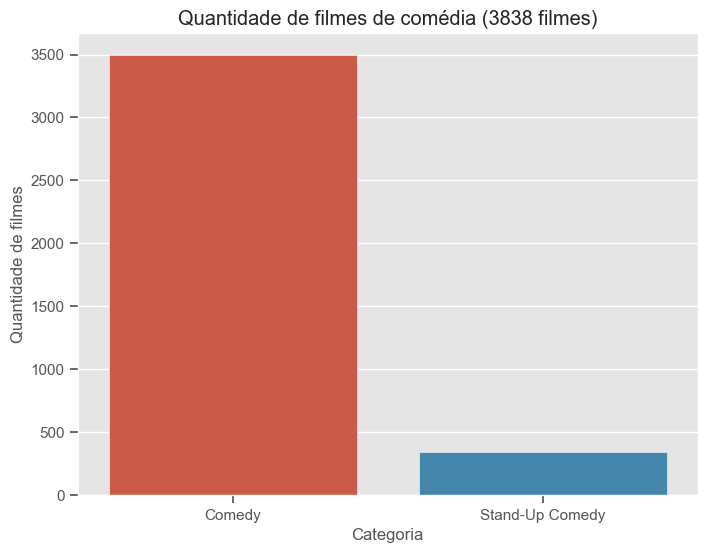

In [370]:
chart_total_movies_in_comedy = sns.barplot(x='treated_listed_in', y='type', data=df_count_movies_in_comedy)
chart_total_movies_in_comedy.set(xlabel='Categoria', ylabel='Quantidade de filmes', title=f'Quantidade de filmes de comédia ({total_movies_in_comedy} filmes)')
plt.show(chart_total_movies_in_comedy)

#### 5- Lista de todos os gêneros de filmes.

In [285]:
# Criando uma lista com todas as categorias de filmes
movies_list = df_listed_in['treated_listed_in'].loc[(df_listed_in.type == 'Movie')].unique().tolist()

# Ordenando a lista por ordem alfabética
movies_list.sort()

# Removendo da lista o item "Movies", por não se tratar de um genêro e sim uma má classificação da base de dados
movies_list.remove('Movies')

# Lista de todos os genênros presentes na base de dados
print(f"Lista com todos o genêros de filmes encontrados na base de dados: {movies_list}.")

Lista com todos o genêros de filmes encontrados na base de dados: ['Action', 'Adventure', 'Animation', 'Anime', 'Arthouse', 'Arts', 'Children and Family', 'Classic', 'Comedy', 'Cult', 'Culture', 'Documentary', 'Drama', 'Entertainment', 'Faith and Spirituality', 'Fantasy', 'Fitness', 'Historical', 'Horror', 'Independent', 'International', 'Kids', 'LGBTQ', 'Military and War', 'Music Videos and Concerts', 'Music and Musicals', 'Romance', 'Sci-Fi', 'Special Interest', 'Sports', 'Stand-Up Comedy', 'Suspense', 'Talk Show and Variety', 'Thrillers', 'Unscripted', 'Western', 'Young Adult Audience'].


In [374]:
# Criando um DataFrame com a contagem de filmes por gênero
df_movie_count = df_listed_in.loc[df_listed_in.type == 'Movie', 'treated_listed_in'].value_counts().reset_index().rename(columns={'index': 'genre', 'treated_listed_in':'count'})
df_movie_count#.columns = ['Genre', 'Count']

# # Ordenando os gêneros por ordem alfabética
# df_movie_count = df_movie_count.sort_values('Genre')
# df_movie_count

,genre,count
0,Drama,5633
1,Comedy,3495
2,International,3036
3,Action,2361
4,Documentary,1548
5,Suspense,1381
6,Romance,1208
7,Horror,1202
8,Adventure,1089
9,Independent,756


#### 6- A frequência de "Movie" de todos os dados e comparativamente em relação as duas plataformas

In [286]:
# Frequência absoluta de TV Show na base de dados completa
absolute_freq_tv_show_total = titles.type.loc[titles.type == 'TV Show'].value_counts()
absolute_freq_tv_show_total

TV Show    4530
Name: type, dtype: int64

In [287]:
# Frequência relativa de TV Show para cada plataforma
relative_freq_tv_show_total = absolute_freq_tv_show_total / titles.type.value_counts().sum()
relative_freq_tv_show_total

TV Show    0.245196
Name: type, dtype: float64

In [288]:
# Frequência absoluta de TV Show para cada paltaforma
# titles.groupby('type')['platform'].value_counts()['TV Show']
absolute_freq_tv_show_plat = titles[['type', 'platform']].loc[titles.type == 'TV Show'].value_counts()
absolute_freq_tv_show_plat

type     platform    
TV Show  Netflix         2676
         Amazon Prime    1854
dtype: int64

In [289]:
absolute_freq_tv_show_plat['TV Show']['Netflix']

2676

In [290]:
# Frequência relativa de TV Show para cada plataforma
relative_freq_tv_show_plat = absolute_freq_tv_show_plat / absolute_freq_tv_show_plat.sum()
relative_freq_tv_show_plat

type     platform    
TV Show  Netflix         0.590728
         Amazon Prime    0.409272
dtype: float64

In [291]:
print(f"A frequência absoluta de TV Show na base de dados é: {absolute_freq_tv_show_total['TV Show']}.")
print(f"A frequência absoluta de TV Show somente para dados da Netflix é: {absolute_freq_tv_show_plat['TV Show']['Netflix']}.")
print(f"A frequência absoluta de TV Show somente para dados da Amazon Prime é: {absolute_freq_tv_show_plat['TV Show']['Amazon Prime']}.")
print(f"A frequência relativa de TV Show na base de dados é: {relative_freq_tv_show_total['TV Show']}.")
print(f"A frequência relativa de TV Show somente para dados da Netflix é: {relative_freq_tv_show_plat['TV Show']['Netflix']}.")
print(f"A frequência relativa de TV Show somente para dados da Amazon Prime é: {relative_freq_tv_show_plat['TV Show']['Amazon Prime']}.")

A frequência absoluta de TV Show na base de dados é: 4530.
A frequência absoluta de TV Show somente para dados da Netflix é: 2676.
A frequência absoluta de TV Show somente para dados da Amazon Prime é: 1854.
A frequência relativa de TV Show na base de dados é: 0.24519621109607578.
A frequência relativa de TV Show somente para dados da Netflix é: 0.590728476821192.
A frequência relativa de TV Show somente para dados da Amazon Prime é: 0.40927152317880794.


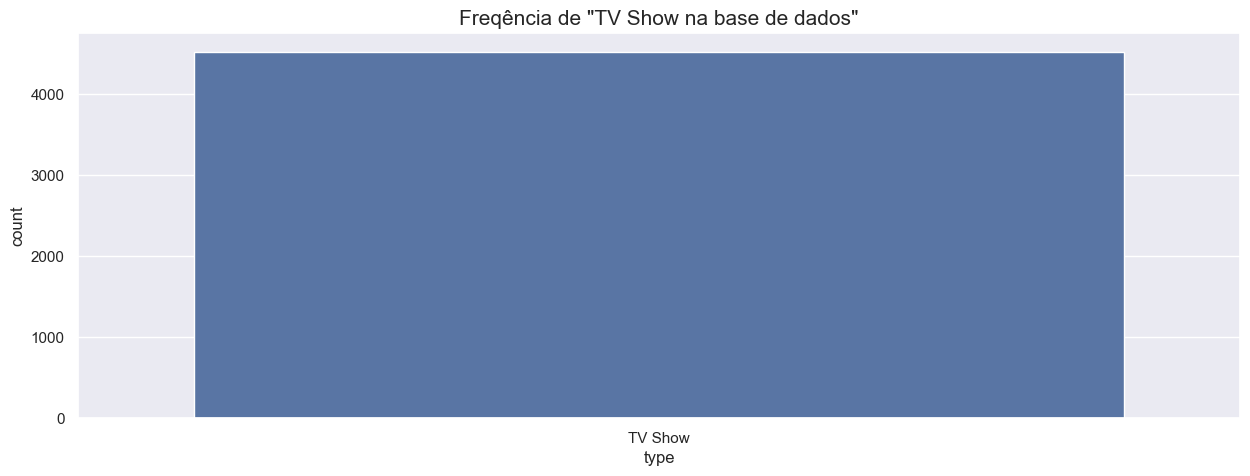

In [392]:
chart_freq_tv_show = sns.countplot(data=titles.loc[titles.type == 'TV Show'], x='type')
chart_freq_tv_show.set_title('Freqência de "TV Show na base de dados"', fontsize = 15)
plt.show(chart_freq_tv_show)

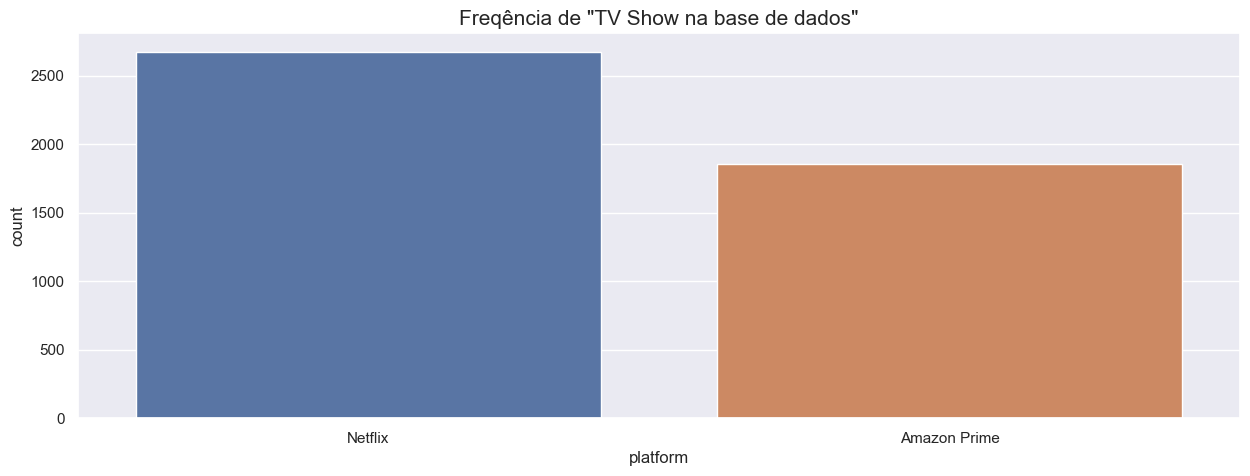

In [393]:
chart_freq_tv_show_by_platform = sns.countplot(data=titles.loc[titles.type == 'TV Show'], x='platform')
chart_freq_tv_show_by_platform.set_title('Freqência de "TV Show na base de dados"', fontsize = 15)
plt.show(chart_freq_tv_show_by_platform)

#### 7- A frequência de "Movies" de todos os dados e comparativamente em relação as duas plataformas

In [292]:
# Frequência absoluta de Movie na base de dados completa
absolute_freq_movie_total = titles.type.loc[titles.type == 'Movie'].value_counts()
absolute_freq_movie_total

Movie    13945
Name: type, dtype: int64

In [293]:
# Frequência relativa de Movie para cada plataforma
relative_freq_movie_total = absolute_freq_movie_total / titles.type.value_counts().sum()
relative_freq_movie_total

Movie    0.754804
Name: type, dtype: float64

In [294]:
# Frequência absoluta de Movie para cada paltaforma
absolute_freq_movie_plat = titles[['type', 'platform']].loc[titles.type == 'Movie'].value_counts()
absolute_freq_movie_plat

type   platform    
Movie  Amazon Prime    7814
       Netflix         6131
dtype: int64

In [295]:
# Frequência relativa de Movie para cada plataforma
relative_freq_movie_plat = absolute_freq_movie_plat / absolute_freq_movie_plat.sum()
relative_freq_movie_plat

type   platform    
Movie  Amazon Prime    0.560344
       Netflix         0.439656
dtype: float64

In [296]:
print(f"A frequência absoluta de Movie na base de dados é: {absolute_freq_movie_total['Movie']}.")
print(f"A frequência absoluta de Movie somente para dados da Netflix é: {absolute_freq_movie_plat['Movie']['Netflix']}.")
print(f"A frequência absoluta de Movie somente para dados da Amazon Prime é: {absolute_freq_movie_plat['Movie']['Amazon Prime']}.")
print(f"A frequência relativa de Movie na base de dados é: {relative_freq_movie_total['Movie']}.")
print(f"A frequência relativa de Movie somente para dados da Netflix é: {relative_freq_movie_plat['Movie']['Netflix']}.")
print(f"A frequência relativa de Movie somente para dados da Amazon Prime é: {relative_freq_movie_plat['Movie']['Amazon Prime']}.")

A frequência absoluta de Movie na base de dados é: 13945.
A frequência absoluta de Movie somente para dados da Netflix é: 6131.
A frequência absoluta de Movie somente para dados da Amazon Prime é: 7814.
A frequência relativa de Movie na base de dados é: 0.7548037889039242.
A frequência relativa de Movie somente para dados da Netflix é: 0.43965579060595195.
A frequência relativa de Movie somente para dados da Amazon Prime é: 0.560344209394048.


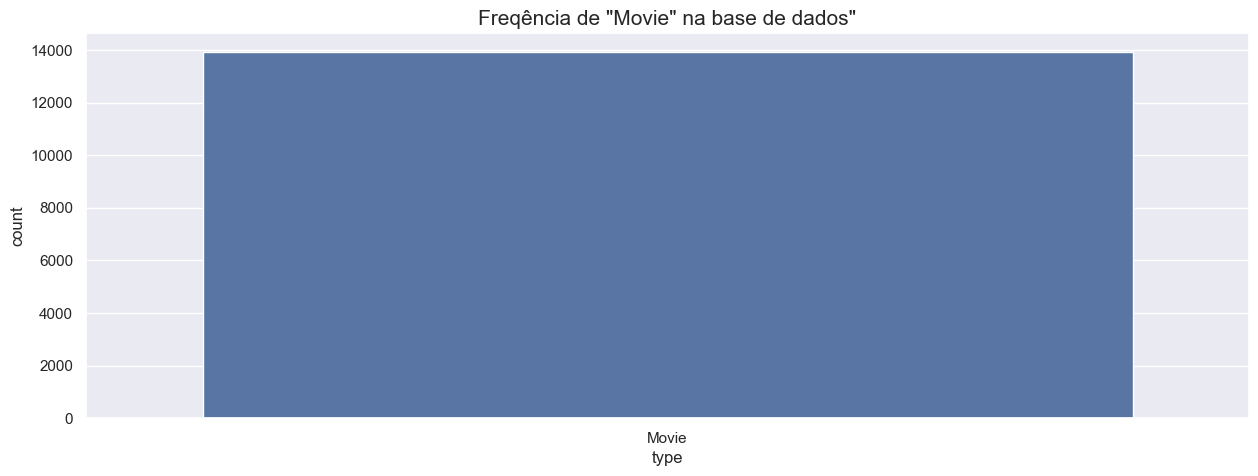

In [390]:
chart_freq_movie = sns.countplot(data=titles.loc[titles.type == 'Movie'], x='type')
chart_freq_movie.set_title('Freqência de "Movie" na base de dados"', fontsize = 15)
plt.show(chart_freq_movie)

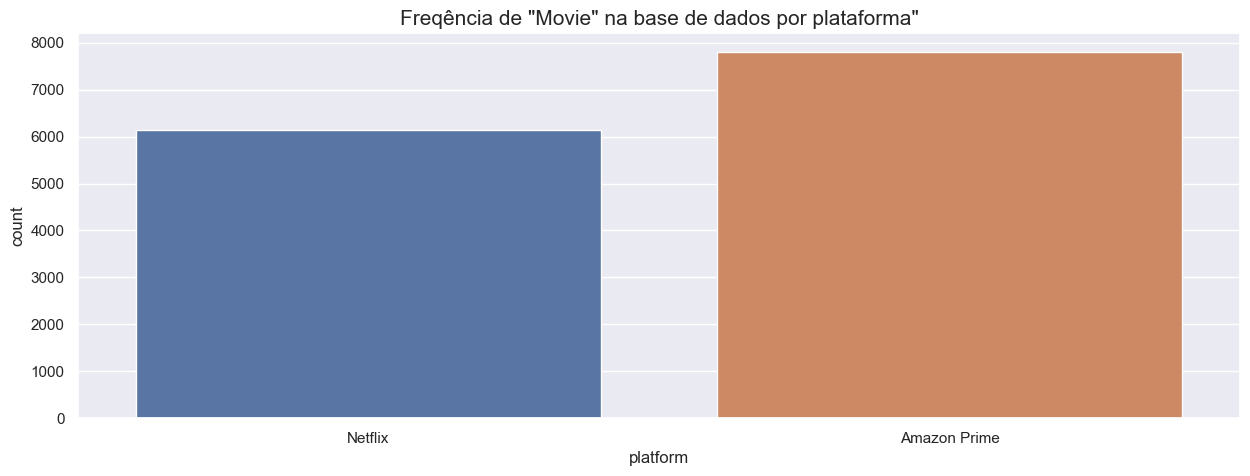

In [391]:
chart_freq_movie_by_platform = sns.countplot(data=titles.loc[titles.type == 'Movie'], x='platform')
chart_freq_movie_by_platform.set_title('Freqência de "Movie" na base de dados por plataforma"', fontsize = 15)
plt.show(chart_freq_movie_by_platform)